In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

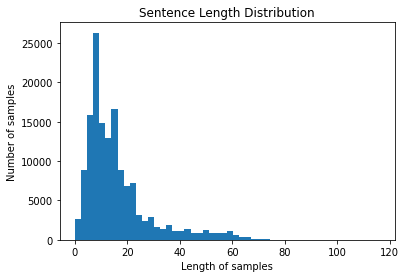

In [6]:
# 3) 모델 구성을 위한 데이터 분석 및 가공
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 문장 길이 분포 시각화
lengths = [len(x) for x in X_train]
plt.hist(lengths, bins=50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sentence Length Distribution')
plt.show()

# 적절한 최대 길이 설정 (예: 40)
max_len = 40

# 패딩 추가
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [7]:
# 4) 모델 구성 및 validation set 구성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split

X_val, X_train_sub, y_val, y_train_sub = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

vocab_size = len(word_to_index)
word_vector_dim = 100

# 모델 1: 평균 풀링 기반
model1 = Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 2: LSTM 기반
model2 = Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=max_len),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# 모델 3: CNN 기반
model3 = Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=max_len),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

models = [model1, model2, model3]

In [8]:
# 5) 모델 훈련 개시
histories = []

for i, model in enumerate(models):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(f"\nTraining model {i+1}...")
    history = model.fit(X_train_sub, y_train_sub, epochs=10, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    histories.append(history)



Training model 1...
Epoch 1/10
229/229 [==============================] - 2s 4ms/step - loss: 0.5502 - accuracy: 0.7660 - val_loss: 0.4050 - val_accuracy: 0.8274
Epoch 2/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3673 - accuracy: 0.8446 - val_loss: 0.3618 - val_accuracy: 0.8432
Epoch 3/10
229/229 [==============================] - 1s 4ms/step - loss: 0.3361 - accuracy: 0.8579 - val_loss: 0.3570 - val_accuracy: 0.8440
Epoch 4/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.8647 - val_loss: 0.3558 - val_accuracy: 0.8452
Epoch 5/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3135 - accuracy: 0.8678 - val_loss: 0.3576 - val_accuracy: 0.8439
Epoch 6/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3078 - accuracy: 0.8718 - val_loss: 0.3605 - val_accuracy: 0.8435
Epoch 7/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3032 - accuracy: 0.8738 - val_loss: 0.3602 - val_ac


Model 1 Training History


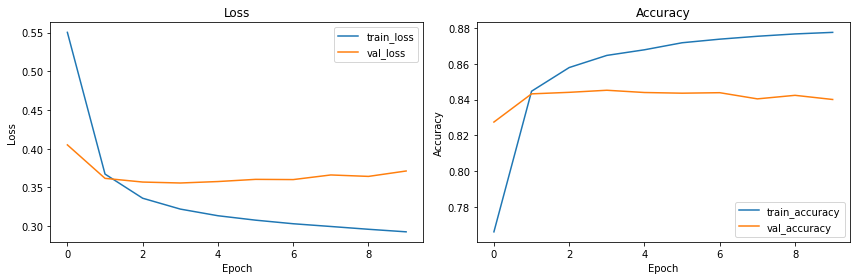


Model 2 Training History


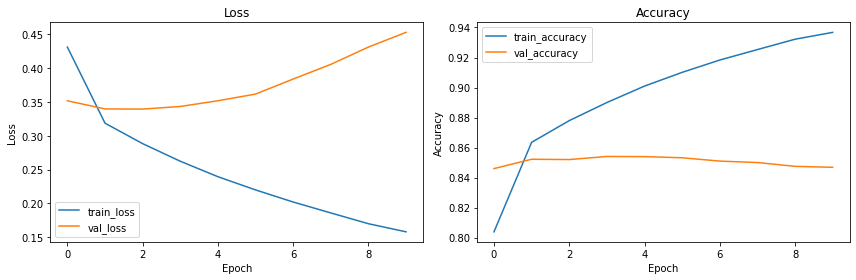


Model 3 Training History


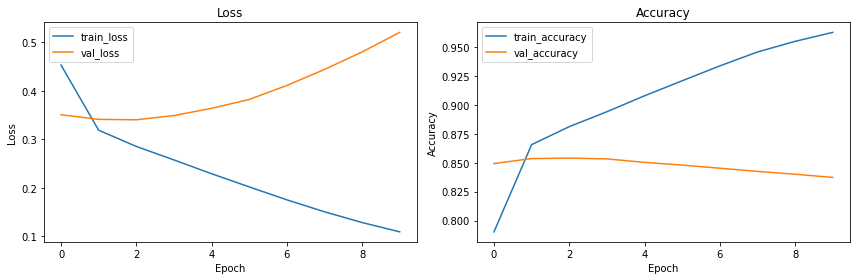

In [9]:
# 6) Loss, Accuracy 그래프 시각화
for i, history in enumerate(histories):
    print(f"\nModel {i+1} Training History")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# 7) 학습된 Embedding 레이어 분석
embedding_layer = model1.layers[0]  # 모델1 사용
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)  # (vocab_size, word_vector_dim)

# 예시: 단어 "영화"의 임베딩 벡터
word = "영화"
if word in word_to_index:
    idx = word_to_index[word]
    print(f"Embedding vector for '{word}':\n", embedding_weights[idx])
else:
    print(f"'{word}' not found in vocabulary.")


(9997, 100)
Embedding vector for '영화':
 [ 6.12890199e-02  1.25757098e-01  8.67639389e-03 -5.24909236e-02
  1.23627849e-01  2.04677228e-02  4.64921147e-02 -6.76909536e-02
 -7.07023516e-02  7.69298375e-02 -8.77567902e-02 -1.80595368e-02
  2.44637169e-02 -1.67441536e-02 -7.26813823e-02  3.47975232e-02
 -1.95578467e-02 -3.03485151e-02  2.79243058e-03  3.43457386e-02
 -3.45720947e-02 -4.83779125e-02 -1.29534416e-02 -7.66066136e-03
 -3.63472141e-02 -4.46711704e-02  1.85013060e-02  1.49492964e-01
  4.13321750e-03 -3.72611396e-02 -1.24505721e-02  7.24529848e-02
  1.02665359e-02 -2.21504606e-02  6.74994886e-02 -5.86860068e-03
  6.30193204e-02 -4.65633348e-02 -1.22512439e-02 -8.24448839e-03
  1.34610847e-01 -6.57530576e-02 -1.19184740e-01 -2.42325589e-02
  5.30983694e-03  1.08286142e-01  4.04975601e-02 -4.13926877e-02
  4.49505188e-02 -2.61954777e-02 -5.45455776e-02 -4.03768523e-03
 -6.66399598e-02  6.33623302e-02  2.01556273e-02  1.11597031e-02
 -7.38780275e-02 -7.31262490e-02 -2.80750450e-02 -

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 100)           999700    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,001,333
Trainable params: 1,633
Non-trainable params: 999,700
_________________________________________________________________
Epoch 1/10
229/229 [==============================] - 1s 3ms/step - loss: 0.6451 - accuracy: 0.6285 - val_loss: 0.5984 - val_accuracy: 0.6892
Epoch 2/10
229/229 [==============================] - 1s 2ms/step - loss: 0.5847 - accuracy: 0.698

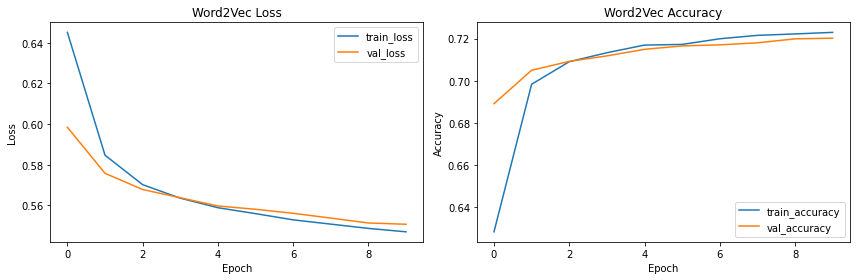

In [19]:
# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
from gensim.models import Word2Vec

word2vec_file_path = '/aiffel/data/word2vec_ko.model'  # 경로는 실제 위치로 변경 필요
word_vectors = Word2Vec.load(word2vec_file_path)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for word, i in word_to_index.items():
    if i < vocab_size and word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]


# Word2Vec 임베딩을 사용하는 모델
model_w2v = Sequential([
    Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_w2v.summary()

history_w2v = model_w2v.fit(X_train_sub, y_train_sub, epochs=10, batch_size=512, validation_data=(X_val, y_val), verbose=1)

# 성능 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['loss'], label='train_loss')
plt.plot(history_w2v.history['val_loss'], label='val_loss')
plt.title('Word2Vec Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['accuracy'], label='train_accuracy')
plt.plot(history_w2v.history['val_accuracy'], label='val_accuracy')
plt.title('Word2Vec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
